# GoogLeNet V3

In [47]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 构建一个卷积组
卷积层+BN层+Rule层

In [48]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

## 各块代码

### Inception块1

In [49]:
class Inception_1(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        # 使用**kwargs的函数可以接受任意数量的命名参数，这些参数在函数内部被处理为一个字典。主要用于有多个可选参数，个数不定的情况。
        # 线路1，单1x1卷积层
        self.p1_1 = BasicConv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = BasicConv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = BasicConv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接3x3卷积层*2
        self.p3_1 = BasicConv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = BasicConv2d(c3[0], c3[1], kernel_size=3, padding=1)
        self.p3_3 = BasicConv2d(c3[1], c3[2], kernel_size=3, padding=1)
        # 线路4，3x3最大池化层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = BasicConv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_3(self.p3_2(self.p3_1(x)))
        p4 = self.p4_2(self.p4_1(x))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

#### 特殊的Inception块1（删去多余1*1卷积层）

In [50]:
class Inception_1_(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c2, c3, **kwargs):
        super().__init__(**kwargs)
        # 使用**kwargs的函数可以接受任意数量的命名参数，这些参数在函数内部被处理为一个字典。主要用于有多个可选参数，个数不定的情况。
        # 线路1，单1x1卷积层(无)
        # 线路2，1x1卷积层后接3x3卷积层,stride = 2
        self.p2_1 = BasicConv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = BasicConv2d(c2[0], c2[1], kernel_size=3, stride=2)
        # 线路3，1x1卷积层后接3x3卷积层*2,stride = 2
        self.p3_1 = BasicConv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = BasicConv2d(c3[0], c3[1], kernel_size=3, padding=1)
        self.p3_3 = BasicConv2d(c3[1], c3[2], kernel_size=3, stride=2)
        # 线路4，3x3最大池化层（删去1x1卷积层）,stride = 2
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_3(self.p3_2(self.p3_1(x)))
        p4 = self.p4_1(x)
        # 在通道维度上连结输出
        return torch.cat((p2, p3, p4), dim=1)

### Inception块2

In [51]:
class Inception_2(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        # 使用**kwargs的函数可以接受任意数量的命名参数，这些参数在函数内部被处理为一个字典。主要用于有多个可选参数，个数不定的情况。
        # 线路1，单1x1卷积层
        self.p1_1 = BasicConv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接1x3卷积层，再接3x1卷积层
        self.p2_1 = BasicConv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = BasicConv2d(c2[0], c2[1], kernel_size=[1, 3], padding=[0, 1])
        self.p2_3 = BasicConv2d(c2[1], c2[2], kernel_size=[3, 1], padding=[1, 0])
        # 线路3，1x1卷积层后接(1x3卷积层，再接3x1卷积层)*2
        self.p3_1 = BasicConv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = BasicConv2d(c3[0], c3[1], kernel_size=[1, 3], padding=[0, 1])
        self.p3_3 = BasicConv2d(c3[1], c3[2], kernel_size=[3, 1], padding=[1, 0])
        self.p3_4 = BasicConv2d(c3[2], c3[3], kernel_size=[1, 3], padding=[0, 1])
        self.p3_5 = BasicConv2d(c3[3], c3[4], kernel_size=[3, 1], padding=[1, 0])
        # 线路4，3x3最大池化层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = BasicConv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_3(self.p2_2(self.p2_1(x)))
        p3 = self.p3_5(self.p3_4(self.p3_3(self.p3_2(self.p3_1(x)))))
        p4 = self.p4_2(self.p4_1(x))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

### Inception块3

In [52]:
class Inception_3(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super().__init__(**kwargs)
        # 使用**kwargs的函数可以接受任意数量的命名参数，这些参数在函数内部被处理为一个字典。主要用于有多个可选参数，个数不定的情况。
        # 线路1，单1x1卷积层
        self.p1_1 = BasicConv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接一个1x3卷积层，一个3x1卷积层，然后合并
        self.p2_1 = BasicConv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2_1 = BasicConv2d(c2[0], c2[1][0], kernel_size=[1, 3], padding=[0, 1])
        self.p2_2_2 = BasicConv2d(c2[0], c2[1][1], kernel_size= [3, 1], padding=[1, 0])
        # 线路3，1x1卷积层后接3*3卷积层，再接一个1x3卷积层，一个3x1卷积层，然后合并
        self.p3_1 = BasicConv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = BasicConv2d(c3[0], c3[1], kernel_size=3, padding=1)
        self.p3_3_1 = BasicConv2d(c3[1], c3[2][0], kernel_size=[1, 3], padding=[0, 1])
        self.p3_3_2 = BasicConv2d(c3[1], c3[2][1], kernel_size=[3, 1], padding=[1, 0])
        # 线路4，3x3最大池化层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = BasicConv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = self.p1_1(x)
        
        p2_1 = self.p2_2_1(self.p2_1(x))
        p2_2 = self.p2_2_2(self.p2_1(x))
        p2 = torch.cat((p2_1, p2_2), dim=1)
        
        p3_1 = self.p3_3_1(self.p3_2(self.p3_1(x)))
        p3_2 = self.p3_3_2(self.p3_2(self.p3_1(x)))
        p3 = torch.cat((p3_1, p3_2), dim=1)
        
        p4 = self.p4_2(self.p4_1(x))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

### 辅助分类器

In [53]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1 = BasicConv2d(in_channels, 128, kernel_size=1)
        self.conv2 = BasicConv2d(128, 768, kernel_size=5, stride=1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.7)
        self.linear = nn.Linear(in_features=768, out_features=out_channels)
        
    def forward(self, x):
        x = self.averagePool(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        out = self.linear(x)
        return out

In [54]:
X = torch.rand(size=(5, 768, 17, 17), device='cuda:0')
Inception = InceptionAux(768, 1000).cuda()

for layer in Inception.children():
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

AvgPool2d output shape:	 torch.Size([5, 768, 5, 5])
BasicConv2d output shape:	 torch.Size([5, 128, 5, 5])
BasicConv2d output shape:	 torch.Size([5, 768, 1, 1])
Flatten output shape:	 torch.Size([5, 768])
Dropout output shape:	 torch.Size([5, 768])
Linear output shape:	 torch.Size([5, 1000])


## 实现代码

In [55]:
conv = nn.Sequential(BasicConv2d(3, 32, kernel_size=3, stride=2),
                     BasicConv2d(32, 32, kernel_size=3, stride=1),
                     BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1),
                     nn.MaxPool2d(3, stride=2, ceil_mode=True),
                     BasicConv2d(64, 80, kernel_size=3),
                     BasicConv2d(80, 192, kernel_size=3, stride=2),
                     BasicConv2d(192, 192, kernel_size=3, padding=1))
# 当 ceil_mode=True 时，池化层会使用向上取整的方式来计算输出的维度。这意味着在进行池化操作时，如果最后一个池化窗口超出了输入特征图的边界，那么仍然会包含这个部分的池化结果，尽管它可能不是完全填满的窗口。
stage_1 = nn.Sequential(Inception_1(192, 64, (48, 64), (64, 96, 96), 32),
                        Inception_1(256, 64, (48, 64), (64, 96, 96), 64),
                        Inception_1(288, 64, (48, 64), (64, 96, 96), 64),
                        Inception_1_(288, (384, 384), (64, 96, 96)))
stage_2 = nn.Sequential(Inception_2(768, 192, (128, 192, 192), (128, 192, 192, 192, 192), 192),
                        Inception_2(768, 192, (160, 192, 192), (160, 192, 192, 192, 192), 192),
                        Inception_2(768, 192, (128, 192, 192), (128, 192, 192, 192, 192), 192))
stage_3 = nn.Sequential(Inception_1_(768, (384, 384), (64, 128, 128)),
                        Inception_3(1280, 320, (384, (384, 384)), (448, 384, (384, 384)), 192),
                        Inception_3(2048, 320, (384, (384, 384)), (448, 384, (384, 384)), 192))

In [56]:
class GoogLeNetV3(nn.Module):
    def __init__(self, aux_logits=True):
        super().__init__()
        self.aux_logits = aux_logits
        self.conv = conv
        self.stage_1 = stage_1
        self.stage_2 = stage_2
        if self.aux_logits == True:
            self.aux = InceptionAux(in_channels=768, out_channels=1000)
        self.stage_3 = stage_3
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(2048, 1000)

    def forward(self, x):
        x = self.conv(x)
        x = self.stage_1(x)
        x = self.stage_2(x)
        aux = None
        if self.training and self.aux_logits:
            aux = self.aux(x)
        x = self.stage_3(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training and self.aux_logits:
            return x, aux
        return x

In [57]:
net = GoogLeNetV3().cuda()

### 将灰度图片改为伪彩色图片，即从一通道变为三通道

In [58]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [59]:
def transform_to_pseudo_color(image):
    # 将PIL图像转换为灰度张量
    transform = transforms.ToTensor()
    gray_tensor = transform(image)
    # 复制单通道到三通道
    return gray_tensor.repeat(3, 1, 1)

def load_data_fashion_mnist(batch_size, resize=None):
    """使用伪彩色图像加载Fashion-MNIST数据集"""
    # 定义一个包含所有必要转换的组合转换
    trans = []
    if resize:
        trans.append(transforms.Resize(size=resize))
    trans.append(transform_to_pseudo_color)
    trans = transforms.Compose(trans)

    # 加载数据集
    mnist_train = datasets.FashionMNIST(
        root="/home/ly/miniconda3/envs/shiwei/data", train=True, transform=trans, download=True)
    mnist_test = datasets.FashionMNIST(
        root="/home/ly/miniconda3/envs/shiwei/data", train=False, transform=trans, download=True)

    return (DataLoader(mnist_train, batch_size, shuffle=True),
            DataLoader(mnist_test, batch_size, shuffle=False))

In [60]:
def train(net, train_iter, test_iter, num_epochs, lr): #此函数d2l.torch库中本身就有，但我们需要熟悉函数逻辑，这是后面深度学习中最常见的代码
    """用GPU训练模型(此处不需要，因为上面已经将net与X转到GPU中了)，模型使用Adam，损失函数是交叉熵"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.cuda(), y.cuda() #训练集的数据移动到device上
            y_hat, aux = net(X)# 返回主分类器和辅助分类器，但此处只使用了主分类器，辅助分类器主要起正则化作用
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec')

loss 0.140, train acc 0.949, test acc 0.926
230.1 examples/sec


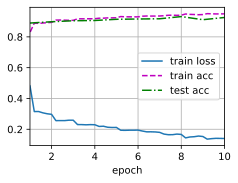

In [62]:
batch_size = 64
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=299)
lr, num_epochs= 0.001, 10
train(net, train_iter, test_iter, num_epochs, lr)

使用：
  1.**BN层**，设置了一个卷积组：卷积层+BN层+Rule层
  2.**并联层聚合**，例如Inception3